# Work
請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響  
請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y   

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 15
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.75, 0.9]
redice_lr_patient = [5, 10, 15]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W1015 22:13:46.089814 10344 deprecation_wrapper.py:119] From C:\Coding\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1015 22:13:46.090768 10344 deprecation_wrapper.py:119] From C:\Coding\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1015 22:13:46.093774 10344 deprecation_wrapper.py:119] From C:\Coding\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1015 22:13:46.174134 10344 deprecation_wrapper.py:119] From C:\Coding\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_defa

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W1015 22:13:46.366081 10344 deprecation_wrapper.py:119] From C:\Coding\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1015 22:13:46.375966 10344 deprecation_wrapper.py:119] From C:\Coding\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W1015 22:13:46.459332 10344 deprecation.py:323] From C:\Coding\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 7s 136us/step - loss: 2.2440 - acc: 0.2593 - val_loss: 2.1809 - val_acc: 0.3017
Epoch 2/15
50000/50000 [==============================] - 6s 114us/step - loss: 1.7654 - acc: 0.3869 - val_loss: 1.8266 - val_acc: 0.3776
Epoch 3/15
50000/50000 [==============================] - 6s 114us/step - loss: 1.6405 - acc: 0.4264 - val_loss: 1.6896 - val_acc: 0.4160
Epoch 4/15
50000/50000 [==============================] - 6s 118us/step - loss: 1.5674 - acc: 0.4515 - val_loss: 1.6389 - val_acc: 0.4293
Epoch 5/15
50000/50000 [==============================] - 6s 119us/step - loss: 1.5124 - acc: 0.4729 - val_loss: 1.5976 - val_acc: 0.4372
Epoch 6/15
50000/50000 [==============================] - 6s 114us/step - loss: 1.4672 - acc: 0.4865 - val_loss: 1.5619 - val_acc: 0.4538
Epoch 7/15
50000/50000 [==============================] - 6s 116us/step - loss: 1.4297 - acc: 0.5007 - val_loss: 1.5555 - 

50000/50000 [==============================] - 5s 101us/step - loss: 1.3855 - acc: 0.5137 - val_loss: 1.5479 - val_acc: 0.4560
Epoch 9/15
50000/50000 [==============================] - 6s 115us/step - loss: 1.3569 - acc: 0.5257 - val_loss: 1.5338 - val_acc: 0.4634
Epoch 10/15
50000/50000 [==============================] - 7s 147us/step - loss: 1.3282 - acc: 0.5363 - val_loss: 1.5111 - val_acc: 0.4654
Epoch 11/15
50000/50000 [==============================] - 8s 156us/step - loss: 1.3028 - acc: 0.5472 - val_loss: 1.5064 - val_acc: 0.4693
Epoch 12/15
50000/50000 [==============================] - 7s 135us/step - loss: 1.2793 - acc: 0.5546 - val_loss: 1.4948 - val_acc: 0.4743
Epoch 13/15
50000/50000 [==============================] - 6s 125us/step - loss: 1.2571 - acc: 0.5617 - val_loss: 1.4998 - val_acc: 0.4763
Epoch 14/15
50000/50000 [==============================] - 6s 130us/step - loss: 1.2358 - acc: 0.5704 - val_loss: 1.4810 - val_acc: 0.4812
Epoch 15/15
50000/50000 [===============

50000/50000 [==============================] - 7s 144us/step - loss: 1.2412 - acc: 0.5672 - val_loss: 1.4714 - val_acc: 0.4835
Numbers of exp: 7, reduce_factor: 0.90, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_23 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense) 

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 10s 206us/step - loss: 1.7675 - acc: 0.3865 - val_loss: 2.0593 - val_acc: 0.3278
Epoch 2/15
50000/50000 [==============================] - 9s 176us/step - loss: 1.4778 - acc: 0.4773 - val_loss: 1.9072 - val_acc: 0.3630
Epoch 3/15
50000/50000 [==============================] - 9s 176us/step - loss: 1.3687 - acc: 0.5183 - val_loss: 1.8922 - val_acc: 0.3639
Epoch 4/15
50000/50000 [==============================] - 8s 169us/step - loss: 1.2844 - acc: 0.5478 - val_loss: 1.6912 - val_acc: 0.4301
Epoch 5/15
50000/50000 [==============================] - 5s 110us/step - loss: 1.2189 - acc: 0.5712 - val_loss: 1.7159 - val_acc: 0.4096
Epoch 6/15
50000/50000 [==============================] - 6s 112us/step - loss: 1.1564 - acc: 0.5952 - val_loss: 1.9238 - val_acc: 0.3722
Epoch 7/15
50000/50000 [==============================] - 6s 116us/step - loss: 1.1044 - acc: 0.6113 - val_loss: 2.0349 -

50000/50000 [==============================] - 7s 136us/step - loss: 1.1711 - acc: 0.5868 - val_loss: 1.5015 - val_acc: 0.4649
Epoch 8/15
50000/50000 [==============================] - 8s 154us/step - loss: 1.1237 - acc: 0.6053 - val_loss: 1.4921 - val_acc: 0.4703
Epoch 9/15
50000/50000 [==============================] - 9s 172us/step - loss: 1.0821 - acc: 0.6192 - val_loss: 1.5479 - val_acc: 0.4631
Epoch 10/15
50000/50000 [==============================] - 7s 150us/step - loss: 1.0389 - acc: 0.6347 - val_loss: 1.4070 - val_acc: 0.4999
Epoch 11/15
50000/50000 [==============================] - 7s 148us/step - loss: 1.0064 - acc: 0.6456 - val_loss: 1.4252 - val_acc: 0.4990
Epoch 12/15
50000/50000 [==============================] - 8s 152us/step - loss: 0.9673 - acc: 0.6639 - val_loss: 1.5143 - val_acc: 0.4827
Epoch 13/15
50000/50000 [==============================] - 8s 168us/step - loss: 0.9275 - acc: 0.6787 - val_loss: 1.5214 - val_acc: 0.4701
Epoch 14/15
50000/50000 [================

Epoch 14/15
50000/50000 [==============================] - 9s 175us/step - loss: 0.8838 - acc: 0.6923 - val_loss: 1.4453 - val_acc: 0.4972
Epoch 15/15
50000/50000 [==============================] - 9s 178us/step - loss: 0.8498 - acc: 0.7073 - val_loss: 1.5249 - val_acc: 0.4833
Numbers of exp: 14, reduce_factor: 0.75, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_43 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
ba

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 8s 154us/step - loss: 1.7619 - acc: 0.3843 - val_loss: 1.8575 - val_acc: 0.3643
Epoch 2/15
50000/50000 [==============================] - 5s 96us/step - loss: 1.4809 - acc: 0.4791 - val_loss: 1.7777 - val_acc: 0.3873
Epoch 3/15
50000/50000 [==============================] - 8s 157us/step - loss: 1.3873 - acc: 0.5103 - val_loss: 1.5447 - val_acc: 0.4529
Epoch 4/15
50000/50000 [==============================] - 9s 182us/step - loss: 1.3112 - acc: 0.5399 - val_loss: 1.7574 - val_acc: 0.3832
Epoch 5/15
50000/50000 [==============================] - 8s 169us/step - loss: 1.2497 - acc: 0.5609 - val_loss: 1.5920 - val_acc: 0.4305
Epoch 6/15
50000/50000 [==============================] - 9s 174us/step - loss: 1.1928 - acc: 0.5800 - val_loss: 1.7870 - val_acc: 0.3901
Epoch 7/15
50000/50000 [==============================] - 8s 161us/step - loss: 1.1405 - acc: 0.6012 - val_loss: 1.5761 - v

50000/50000 [==============================] - 7s 133us/step - loss: 1.1280 - acc: 0.6011 - val_loss: 2.0531 - val_acc: 0.3057

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/15
50000/50000 [==============================] - 6s 119us/step - loss: 1.0060 - acc: 0.6507 - val_loss: 1.5886 - val_acc: 0.4443
Epoch 10/15
50000/50000 [==============================] - 6s 116us/step - loss: 0.9632 - acc: 0.6672 - val_loss: 1.4456 - val_acc: 0.4900
Epoch 11/15
50000/50000 [==============================] - 6s 115us/step - loss: 0.9264 - acc: 0.6799 - val_loss: 1.4101 - val_acc: 0.5042
Epoch 12/15
50000/50000 [==============================] - 6s 116us/step - loss: 0.8920 - acc: 0.6917 - val_loss: 1.4471 - val_acc: 0.4986
Epoch 13/15
50000/50000 [==============================] - 6s 112us/step - loss: 0.8623 - acc: 0.7046 - val_loss: 1.5730 - val_acc: 0.4654
Epoch 14/15
50000/50000 [==============================] - 6s 117us/step - loss: 0.8331 - acc: 0.7

Epoch 15/15
50000/50000 [==============================] - 8s 167us/step - loss: 0.8622 - acc: 0.7034 - val_loss: 1.7583 - val_acc: 0.4234
Numbers of exp: 21, reduce_factor: 0.75, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_64 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_65 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_lay

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 10s 208us/step - loss: 1.8316 - acc: 0.3686 - val_loss: 1.9871 - val_acc: 0.3447
Epoch 2/15
50000/50000 [==============================] - 8s 169us/step - loss: 1.5225 - acc: 0.4663 - val_loss: 2.6133 - val_acc: 0.2546
Epoch 3/15
50000/50000 [==============================] - 9s 178us/step - loss: 1.4133 - acc: 0.5038 - val_loss: 3.2345 - val_acc: 0.2211
Epoch 4/15
50000/50000 [==============================] - 9s 176us/step - loss: 1.3390 - acc: 0.5305 - val_loss: 2.2017 - val_acc: 0.2995
Epoch 5/15
50000/50000 [==============================] - 9s 181us/step - loss: 1.2768 - acc: 0.5521 - val_loss: 1.9475 - val_acc: 0.3460
Epoch 6/15
50000/50000 [==============================] - 7s 144us/step - loss: 1.2165 - acc: 0.5758 - val_loss: 1.9001 - val_acc: 0.3796
Epoch 7/15
50000/50000 [==============================] - 6s 126us/step - loss: 1.1668 - acc: 0.5935 - val_loss: 1.7450 -

50000/50000 [==============================] - 7s 148us/step - loss: 1.1713 - acc: 0.5910 - val_loss: 1.9011 - val_acc: 0.3817
Epoch 8/15
50000/50000 [==============================] - 9s 171us/step - loss: 1.1302 - acc: 0.6044 - val_loss: 1.9547 - val_acc: 0.3670
Epoch 9/15
50000/50000 [==============================] - 8s 153us/step - loss: 1.0881 - acc: 0.6212 - val_loss: 1.6342 - val_acc: 0.4311
Epoch 10/15
50000/50000 [==============================] - 7s 144us/step - loss: 1.0530 - acc: 0.6345 - val_loss: 1.8635 - val_acc: 0.3898
Epoch 11/15
50000/50000 [==============================] - 6s 119us/step - loss: 1.0148 - acc: 0.6482 - val_loss: 1.6056 - val_acc: 0.4633
Epoch 12/15
50000/50000 [==============================] - 7s 135us/step - loss: 0.9826 - acc: 0.6593 - val_loss: 1.6763 - val_acc: 0.4324
Epoch 13/15
50000/50000 [==============================] - 7s 135us/step - loss: 0.9448 - acc: 0.6750 - val_loss: 1.5242 - val_acc: 0.4696
Epoch 14/15
50000/50000 [================

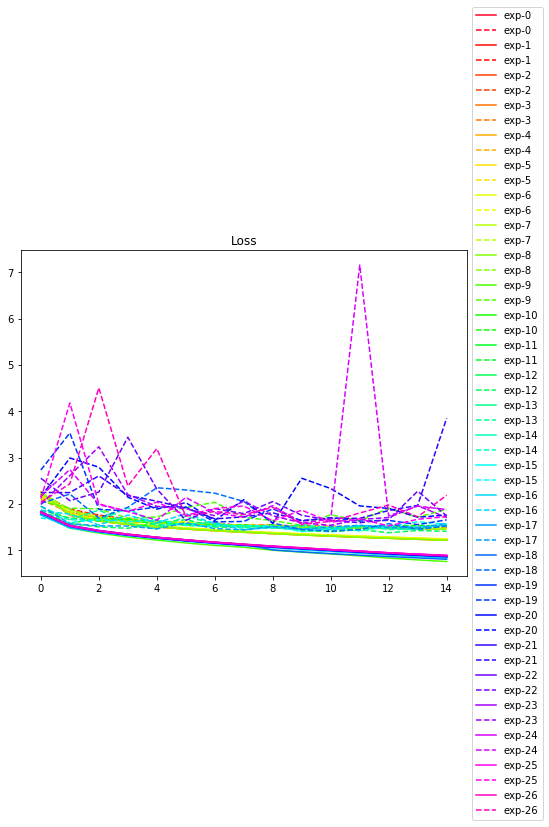

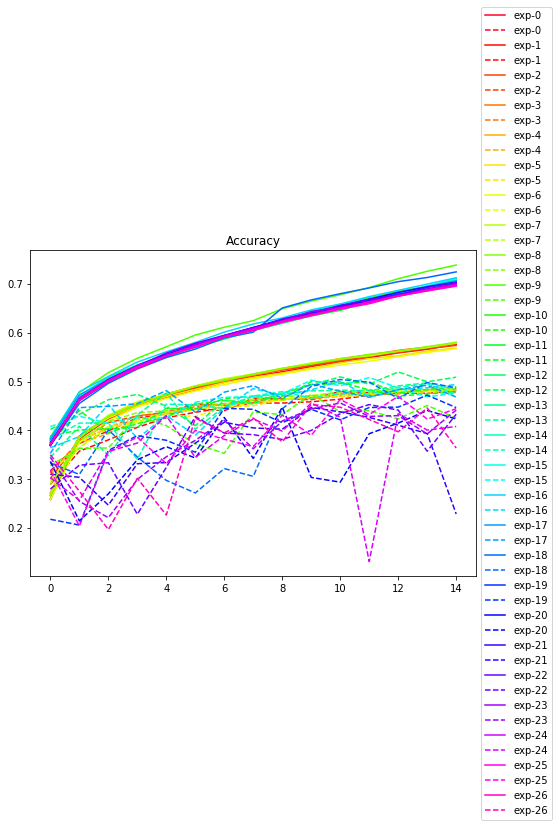

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()